<a href="https://colab.research.google.com/github/KaviyaKanakaraj/Titanic-Survival-Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Practice: Titanic Survival Prediction**

**Problem Statement:** On April 15, 1912, the RMS Titanic sank after colliding with an iceberg, resulting in the death of 1502 out of 2224 passengers and crew.

Is there any way to predict which passengers are more likely to survive?

**Dataset** downloaded from https://www.kaggle.com/competitions/titanic/data

# **Step 1: Installation**
The following libraries are required,


1. **Pandas**: Includes dataFrames for tabular data, reading/writing CSV and data wrangling utilities, used in this case to load the Titanic CSV, inspect columns, clean data.
2. **Numpy**: Includes fast numerical arrays and math operations used under the hood by many libraries for efficient numeric processing.
3. **Scikit-Learn**: It is widely used for its ML toolkit: models, preprocessing, metrics, train/test splits.
4. **Seaborn**: Used for statistical data visualization built on top of Matplotlib.
5. **Matplotlib**: It is a core Python plotting library, used here for plotting feature importances and charts.

In [ ]:
!pip install pandas numpy scikit-learn seaborn matplotlib

#**Step 2: Read Dataset**

**Goal**: Load the Titanic training dataset into memory for exploration.

**Key functions**:

pd.read_csv(path) - Reads a comma-separated values file into a DataFrame.

head() - Quick preview of top rows to confirm successful load and column names.

In [17]:
import pandas as pd

df = pd.read_csv('/content/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#**Step 3: Understanding the Dataset**

**Goal**: Inspect schema, data types, ranges, and missing values before modeling.

**Useful inspection functions:**

* **df.info()** – Column names, data types (numeric vs object), and non‑null counts.
*   **df.describe()** – Summary stats (count, mean, std, quartiles) for numeric cols.
* **df.isnull().sum()** – Count missing values per column.

Below is a quick description of each original column in the Kaggle Titanic training data:

1. **PassengerId**: Unique numeric value for each passenger on board.
2. **Survived**: Binary value assigned to each passenger based on whether they survived the wreck or not, i.e., 1 for passengers who survived, 0 for passengers who did not survive.
3. **Pclass**: Numberic value representing the ticket class of each passenger, consisting of 1st class, 2nd class and 3rd class.
4. **Name**: String value representing the name of the passenger.
5. **Sex**: String value representing the gender of the passenger.
6. **Age**: Numeric value representing the age of the passenger.
7. **SibSp**: Numeric value that represents the number of siblings/spouses of the passenger on board.
8. **Parch**: Numeric value that represents the number of parents/children of the passenger on board.
9. **Ticket**: String value representing th ticket number of the passenger.
10. **Fare**: Numeric value representing the ticket fare paid by the passenger.
11. **Cabin**: String value representing the cabin assigned to the passenger.
12. **Embarked**: String value representing the location of boarding of the passenger.

In [18]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


#**Step 4: Data Pre-processing**

**Goal**: Convert raw data into a clean, numeric feature table suitable for ML models.

**Why preprocess?**

* ML estimators in scikit-learn expect numeric arrays (no strings).
* Missing values can break training or bias the model.
* Some features need encoding (categorical → numeric) or combining.

**What steps do we need to apply?**

1. **Impute Age**: Replace missing ages with the median age.
2. **Impute Embarked**: Replace missing ports with the mode.
3. **Encode Sex**: Map to numeric (female→1, male→0); we'll choose female=1 because females historically had higher survival, using 0/1 works for most models.
4. **One-Hot Encode Embarked**: Convert categories (C,Q,S) to dummy columns using pd.get_dummies(..., drop_first=True) to avoid redundant collinearity.

> **NOTE**: Here, *pd.get_dummies()* converts categorical variables, like Embarked which has values ['S', 'C', 'Q'] into dummy variables (also called one-hot encoding). This means we replace the single Embarked column with separate columns, one for each category, 'Embarked_C', 'Embarked_Q' and 'Embarked_S'.

> However, when we create dummy variables, all categories add up to 1 (e.g., S + C + Q). This introduces multicollinearity (redundant information) because if two columns are known, the third is obvious.

> *drop_first=True* removes the first dummy column, so if Embarked has 3 categories, we only keep 2 columns ('Embarked_C' and 'Embarked_Q'), which avoids redundancy without losing information.

> We do one-hot encoding instead of labeling/mapping (as used for 'Sex' column), as there are more than two unique value which are treated by some algorithms as having mathematical meaning, as in Q (2) > C (1) > S (0), introducing bias.

5. **Engineer FamilySize**: Combine SibSp + Parch + 1 (self) to capture whether traveling alone vs with family.

6. **Drop Unused Columns**: Remove high-cardinality or mostly-missing columns that add noise in this simple baseline: PassengerId, Name, Ticket, Cabin.

In [19]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode(), inplace=True)
df['Sex'] = df['Sex'].map({'male':1,'female':0})
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
df.head()

/tmp/ipython-input-19-325665814.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-19-325665814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,False,False
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,False,True
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,False,True


In [20]:
df.drop(['PassengerId', 'Name','Ticket'], axis=1, inplace=True)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.drop(['SibSp','Parch'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked_Q,Embarked_S,FamilySize
0,0,3,1,22.0,7.2500,NaN,False,True,2
1,1,1,0,38.0,71.2833,C85,False,False,2
2,1,3,0,26.0,7.9250,NaN,False,True,1
3,1,1,0,35.0,53.1000,C123,False,True,2
4,0,3,1,35.0,8.0500,NaN,False,True,1


#**Step 5: Split Dataset**

**Goal**: Evaluate model performance on unseen data by splitting into training and testing sets.

**Function**: train_test_split(X, y, test_size=..., random_state=...)

*x*: Feature matrix (independent variables).
  
*y*: Target vector (Survived).

*test_size=0.2*: Reserve 20% of rows for final evaluation.

*random_state=42*: Seed for reproducibility; any integer works, but use a fixed value for repeatable splits.

**Why these specific columns for modeling?**

* **Sex**: Major survival determinant ("women and children first").
* **Age**: Children were prioritized in survival aid.
* **Embarked_Q, Embarked_S**: Encoded boarding port; captures demographic/wealth patterns not fully explained by Pclass alone. (Cherbourg is the dropped baseline.)

> **NOTE**: Embarked = Port where the passenger boarded the Titanic, i.e., C → Cherbourg (France), Q → Queenstown (Ireland), S → Southampton (England). It acts as a proxy for social/economic factors, as passengers boarding at Cherbourg (C) were often wealthier, buying first-class tickets, while passengers from Queenstown (Q) were generally steerage/third class, lower socio-economic group. Since class and wealth strongly influenced survival (rich had better access to lifeboats), Embarked correlates with survival rate.

* **Pclass**: Strong socio-economic proxy linked to cabin location & lifeboat access.
* **Fare**: Correlates with wealth and, indirectly, class/cabin placement.
* **FamilySize**: Reflects whether passenger traveled alone or with relatives; moderate family sizes sometimes show higher survival.

>**NOTE**: People traveling with family often tried to help each other during the disaster.  Women and children first → families with kids (Parch > 0) might have had a better chance. But at the same time, too many family members might reduce survival chances (hard to escape together).
So, there’s a non-linear relationship: Small families → higher survival, Large families → lower survival

In [21]:
from sklearn.model_selection import train_test_split

x = df[['Pclass','Sex','Age','Fare','Embarked_Q','Embarked_S','FamilySize']]
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# **Step 6: Model Training**

**Goal**: Fit a baseline Logistic Regression model.

**Why Logistic Regression?**

* Suitable for binary outcomes (0/1).
* Fast to train; good benchmark.
* Outputs class probabilities (via predict_proba).

**Key API**:

*LogisticRegression(max_iter=...)*: Increase max_iter if the solver needs more steps to converge.

*.fit(X_train, y_train)*: Learn model coefficients.

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(x_train,y_train)

LogisticRegression(max_iter=200)

#**Step 7: Evaluation**

**Goal**: Measure how well the model generalizes to unseen data.

**Key metrics/functions:**

*model.predict(X_test)*: Predicted class labels (0/1).

*accuracy_score(y_true, y_pred*): Fraction correctly classified.

In [23]:
from sklearn.metrics import accuracy_score

pred = model.predict(x_test)
print("Accuracy", accuracy_score(y_test, pred))

Accuracy 0.8044692737430168


#**Step 8: Training Other Models**

Trying additional models often boosts performance. Here we’ll fit a Random Forest Classifier – an ensemble of decision trees trained on bootstrapped samples with feature randomness.

**Why Random Forest?**

* Captures non‑linear relationships and feature interactions.
* Robust to outliers and scaling.
* Provides feature importance estimates.

**Key API:**

*RandomForestClassifier(n_estimators=...)* – # of trees (100 is a common starting point).

.*fit(X_train, y_train)* – Train ensemble.

*.predict(X_test)* – Generate predictions.

*.feature_importances_* – Relative importance of each input feature.

In [24]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(x_train,y_train)
rf_pred = model_rf.predict(x_test)
print("Accuracy", accuracy_score(rf_pred,y_test))

Accuracy 0.8268156424581006


#**What is Feature Importance?**

**Definition**: A measure of how much each feature contributed to the model’s predictions.

Available for tree-based models like Random Forest, XGBoost (not for Logistic Regression in the same way).

It’s usually calculated based on:

* Gini Importance (Mean Decrease in Impurity) for decision trees

* Gain/Weight in boosting models

* Or based on permutation importance (shuffling feature values and measuring drop in accuracy)

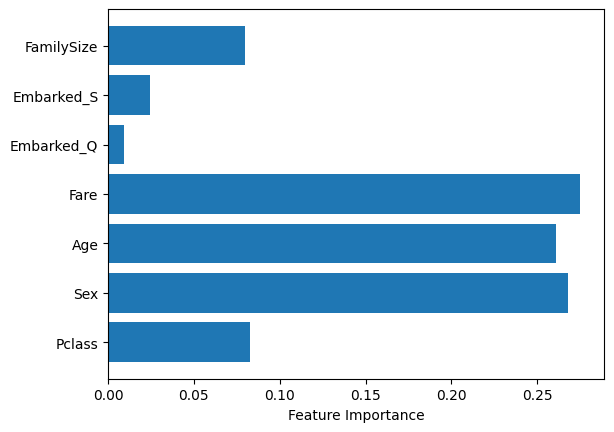

In [25]:
import matplotlib.pyplot as plt

importances = model_rf.feature_importances_
features = x.columns
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.show()

# **Interpretation**

* **Sex (0.32)**: Gender is the strongest predictor (women had much higher survival chances).

* **Pclass (0.21)**: Passenger class matters a lot (1st class > 2nd > 3rd).

* **Fare (0.18)**: Correlates with wealth, and wealth correlated with survival.

* **Age (0.15)**: Children were prioritized for lifeboats.

* **Embarked_S/Q**: Boarding location has some influence but is weaker.

* **FamilySize (0.05)**: Some effect, but less than the main features.